In [1]:
!pip install kymatio

     |████████████████████████████████| 102kB 9.5MB/s 


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
%cd /gdrive/My Drive/Thesis_code

/gdrive/My Drive/Thesis_code


In [4]:
import kymatio
kymatio.__version__

'0.2.0'

In [5]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np 
import pandas as pd 
from google.colab import widgets
import matplotlib.pyplot as plt
from sklearn import preprocessing 
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from utils import file_helper, feature_extraction

# Data Pipeline

In [6]:
train_X = np.load('Dataset/split_data/Multi-Class Split/X_train.npy')
train_y = np.load('Dataset/split_data/Multi-Class Split/y_train.npy')
val_X = np.load('Dataset/split_data/Multi-Class Split/X_val.npy')
val_y = np.load('Dataset/split_data/Multi-Class Split/y_val.npy')
test_X = np.load('Dataset/split_data/Multi-Class Split/X_test.npy')
test_y = np.load('Dataset/split_data/Multi-Class Split/y_test.npy')

# Note: 
# Class     Label     One-hot Encoding
# HUMAN       0     [1, 0, 0, 0 ,0]
# BICYCLE     1     [0, 1, 0, 0, 0]
# PILLAR      2     [0, 0, 1, 0, 0]
# WALL        3     [0, 0, 0, 1, 0]
# CAR         4     [0, 0, 0, 0, 1]

In [7]:
train_X = np.reshape(train_X,(-1,5704))
val_X = np.reshape(val_X,(-1,5704))
test_X = np.reshape(test_X,(-1,5704))
print(train_X.shape)

(93586, 5704)


In [8]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_X, val_y)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_X, test_y)).batch(BATCH_SIZE)

# Wavelet Transform Multi-Class Model

In [9]:
J = 8
T = 5704
Q = 12
log_eps = 1e-6

In [10]:
from kymatio.keras import Scattering1D
from tensorflow.keras import layers
tf.keras.backend.clear_session()
def Wavelet_Simple(): 
    input = layers.Input(shape=(T))
    x = Scattering1D(J, Q = Q)(input)
    x = layers.Lambda(lambda x: x[..., 1:, :])(x)
    # To increase discriminability, we take the logarithm of the scattering
    # coefficients (after adding a small constant to make sure nothing blows up
    # when scattering coefficients are close to zero). This is known as the
    # log-scattering transform.
    x = layers.Lambda(lambda x: tf.math.log(tf.abs(x) + log_eps))(x)
    x = layers.GlobalAveragePooling1D(data_format='channels_first')(x)
    x = layers.BatchNormalization(axis=1)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    output = layers.Dense(5, activation='softmax')(x)
    return tf.keras.models.Model(input, output)


In [11]:
model = Wavelet_Simple()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to identify source code of lambda function <function <lambda> at 0x7f4610043840>. It was defined in this code:
backend.fft = FFT(lambda x: tf.signal.fft(x, name='fft1d'),
                  lambda x: tf.signal.ifft(x, name='ifft1d'),
                  lambda x: tf.math.real(tf.signal.ifft(x, name='irfft1d')),
                  lambda x: None)

This code must contain a single distinguishable lambda. To avoid this problem, define each lambda in a separate expression.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to identify source code of lambda function <function <lambda> at 0x7f4610043840>. It was 

In [12]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5704)]            0         
_________________________________________________________________
scattering1d (Scattering1D)  (None, 337, 23)           0         
_________________________________________________________________
lambda (Lambda)              (None, 336, 23)           0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 336, 23)           0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 336)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 336)               1344      
_________________________________________________________________
flatten (Flatten)            (None, 336)              

In [13]:
METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),

]

# Optimizers, Early Stop, Callbacks, Reduce LR

In [14]:
from tensorflow.keras.optimizers import RMSprop,Adam
model.compile(optimizer = RMSprop(learning_rate = 1e-3), loss = 'categorical_crossentropy',metrics = [METRICS])
import os 
from tensorflow.keras.callbacks import EarlyStopping

#Early stop to avoid overfitting
early_stop = EarlyStopping(patience = 5, verbose = 1)

#Provides unique names for checkpoints and adjust the checkpointing frequency
checkpoint_path = "Wavelet_Multi_RMSProp/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Create a call back that save the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                 save_weights_only = True,
                                                 verbose = 1,
                                                 period = 10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose= 1, min_lr=1e-7)


# Train

In [15]:
model_train = model.fit(train_dataset, 
                        epochs = 100,
                        validation_data = val_dataset,
                        )#,callbacks = [lr_schedule]callbacks = [early_stop],callbacks = [cp_callback]

Epoch 1/100
1463/1463 [==============================] - 302s 206ms/step - loss: 1.0245 - categorical_accuracy: 0.6226 - precision: 0.7279 - recall: 0.4948 - auc: 0.8676 - val_loss: 1.0221 - val_categorical_accuracy: 0.6276 - val_precision: 0.6788 - val_recall: 0.5549 - val_auc: 0.8787
Epoch 2/100
1463/1463 [==============================] - 284s 194ms/step - loss: 0.8656 - categorical_accuracy: 0.6767 - precision: 0.7693 - recall: 0.5687 - auc: 0.9053 - val_loss: 0.9326 - val_categorical_accuracy: 0.6493 - val_precision: 0.7348 - val_recall: 0.5405 - val_auc: 0.8893
Epoch 3/100
1463/1463 [==============================] - 285s 195ms/step - loss: 0.8039 - categorical_accuracy: 0.7013 - precision: 0.7828 - recall: 0.6075 - auc: 0.9183 - val_loss: 0.7682 - val_categorical_accuracy: 0.7148 - val_precision: 0.7777 - val_recall: 0.6445 - val_auc: 0.9262
Epoch 4/100
1463/1463 [==============================] - 284s 194ms/step - loss: 0.7593 - categorical_accuracy: 0.7195 - precision: 0.7937 

In [ ]:
# model.save("Wavelet_Multiclass")
model.save_weights("Wavelet_Multiclass_weights")

# Plot Accuracy vs Loss (Train and Valid)

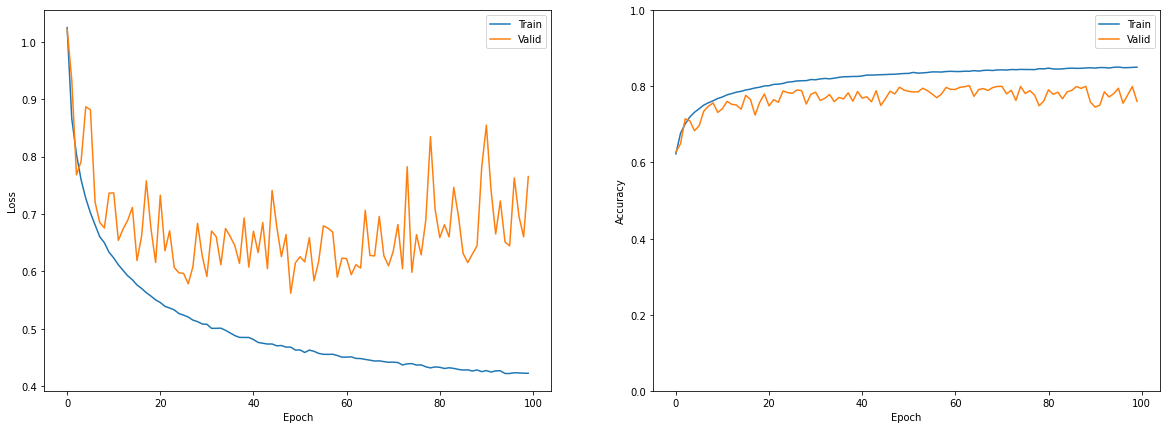

In [20]:
plt.figure(figsize =(20,7))

plt.subplot(1,2,1)
plt.plot(model_train.epoch, model_train.history["loss"], label="Train")
plt.plot(model_train.epoch, model_train.history["val_loss"], label="Valid")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(model_train.epoch, model_train.history["categorical_accuracy"], label="Train")
plt.plot(model_train.epoch, model_train.history["val_categorical_accuracy"], label="Valid")
plt.ylim([0,1.0])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Test the model

In [17]:
test_eval = model.predict(test_X, batch_size = 64)
model.evaluate(test_dataset, batch_size= 64, verbose = 1)

183/183 [==============================] - 30s 166ms/step - loss: 0.7473 - categorical_accuracy: 0.7652 - precision: 0.7906 - recall: 0.7430 - auc: 0.9441


[0.7473293542861938,
 0.7652345299720764,
 0.7906193137168884,
 0.7429818511009216,
 0.9440932869911194]

# Plot classification report

In [18]:
from sklearn.metrics import classification_report
pred = np.round(test_eval, 0)
label = ["HUMAN","BICYCLE","PILLAR", "WALL","CAR"]
target = ["Class {}".format(i) for i in range(5)]
classification_metrics = classification_report(test_y.argmax(1) ,pred.argmax(1), target_names = label)
print(classification_metrics)

              precision    recall  f1-score   support

       HUMAN       0.76      0.96      0.85      4761
     BICYCLE       0.62      0.87      0.73      1106
      PILLAR       0.75      0.51      0.61      1683
        WALL       0.60      0.53      0.56      1297
         CAR       0.91      0.61      0.73      2837

    accuracy                           0.75     11684
   macro avg       0.73      0.70      0.69     11684
weighted avg       0.77      0.75      0.74     11684



/gdrive/My Drive/Thesis_code/utils/confusion_matrix_pretty_print.py:165: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/gdrive/My Drive/Thesis_code/utils/confusion_matrix_pretty_print.py:166: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/gdrive/My Drive/Thesis_code/utils/confusion_matrix_pretty_print.py:168: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/gdrive/My Drive/Thesis_code/utils/confusion_matrix_pretty_print.py:169: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False


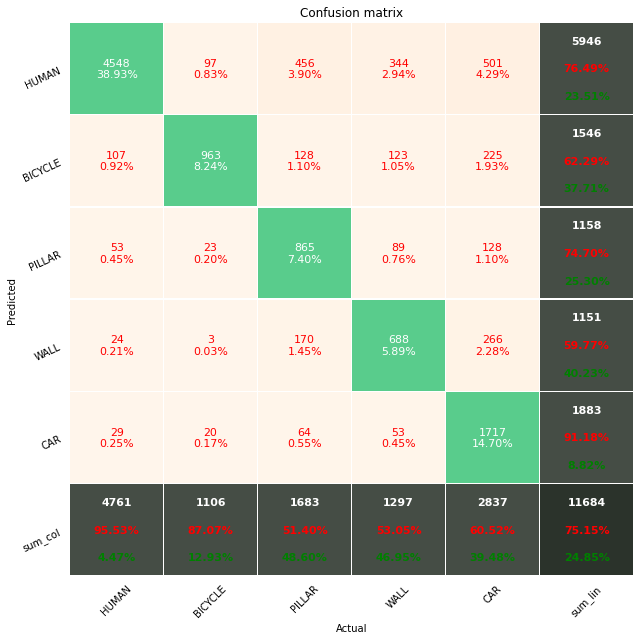

In [19]:
from utils.confusion_matrix_pretty_print import plot_confusion_matrix_from_data

columns = ["HUMAN","BICYCLE","PILLAR","WALL","CAR"]
# columns = []
annot = True
cmap = 'Oranges'
fmt = '.2f'
lw = 0.5
cbar = False
show_null_values = 2
pred_val_axis = 'y'
#size::
fz = 12
figsize = [9,9]
if(len(test_y) > 10):
    fz=9; figsize=[14,14]
plot_confusion_matrix_from_data(test_y.argmax(axis=1), pred.argmax(axis=1), columns,annot, cmap, fmt, fz, lw, cbar, figsize, show_null_values, pred_val_axis)